### КУРСОВОЙ ПРОЕКТ

__Цель курсового проекта:__ отработать на практике полученные теоритические знания в области работы с данными (получение, обработка, обучение на разных выборках). Обучить модель предсказания цен на недвижимость и провести предсказания на тестовой выборке.

Подключение библиотек и скриптов используемых в проекте

In [1]:
import numpy as np  
import pandas as pd

import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [2]:
matplotlib.rcParams.update({'font.size': 14}) # устанавливаем размер шрифта используемый при создании графических изображений

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3))) 
    # вывод коэффициента детерминации на обучающей выборке
    
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3))) 
    # вывод коэффициента детерминации на тестовой выборке
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.show()   
    

загружаем датасеты тестовый и обучающий

In [4]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### Описание полей используемого датасета


__`Id`__ - идентификационный номер квартиры,

__`DistrictId`__ - идентификационный номер района,

__`Rooms`__ - количество комнат,

__`Square`__ - площадь,

__`LifeSquare`__ - жилая площадь,

__`KitchenSquare`__ - площадь кухни,

__`Floor`__ - этаж,

__`HouseFloor`__ - количество этажей в доме,

__`HouseYear`__ - год постройки дома,

__`Ecology_1, Ecology_2, Ecology_3`__ - экологические показатели местности,

__`Social_1, Social_2, Social_3`__ - социальные показатели местности,

__`Healthcare_1, Helthcare_2`__ - показатели местности, связанные с охраной здоровья,

__`Shops_1, Shops_2`__ - показатели, связанные с наличием магазинов, торговых центров,

__`Price`__ - цена квартиры.

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail(10)

# проверяем загрузился ли датасет. Берем 10 значений с конца

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9990,15233,1,3.0,57.373889,39.688445,5.0,2,5.0,1962,0.036270,B,B,6,1318,1,200.0,1,1,B,163807.542987
9991,11553,3,3.0,101.622794,51.628780,12.0,18,17.0,2000,0.265089,B,B,37,5288,0,1937.0,3,2,B,212883.501504
9992,14333,150,3.0,78.249637,49.385096,10.0,5,16.0,1976,0.300323,B,B,52,10311,6,NaN,1,9,B,342418.758888
9993,48,13,3.0,80.631333,48.899083,10.0,11,14.0,1999,0.090799,B,B,74,19083,2,NaN,5,15,B,350684.628560
9994,4158,23,2.0,64.864198,NaN,1.0,17,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,171323.515653
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [6]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head(10)

# проверяем загрузился ли датасет. Берем 10 значений с начала

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
5,7633,53,1.0,40.675627,NaN,1.0,21,21.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
6,13329,23,2.0,68.099538,64.843025,1.0,2,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
7,5502,32,2.0,48.193897,32.857644,6.0,5,14.0,1972,0.135650,B,B,46,7960,6,350.0,3,11,B
8,4220,96,3.0,72.277106,45.968758,9.0,17,17.0,1997,0.041116,B,B,53,14892,4,NaN,1,4,B
9,11538,6,3.0,80.219400,47.660260,9.0,13,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B


В загруженных датасетах train и test имеются пропуски в некоторых данных, поэтому датасеты необходимо дополнительно обрабатывать  пропуски

In [7]:
train_df.shape[1]-1 == test_df.shape[1] 

# сравниваем количество признаков в двух датасетах. в train используем -1, т.к. есть price

True

### Приведение типов

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Приводим не числовые признаки к строковому значению (Id и DistrictId)

In [9]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Id и DistrictId изменили значение с float64 на object

### Работа с целевой переменной PRICE


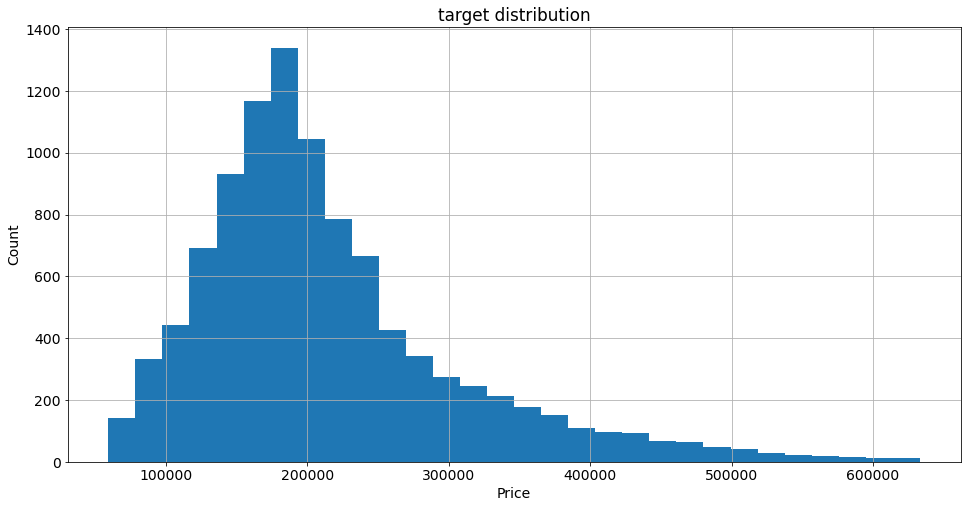

In [11]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('target distribution')
plt.show()

на данном графике наблюдаем длинный "хвост" стоимости цены недвижимости после 500 000$. Необходимо посмотреть что это за недвижимость с такой большой стоимостью и не является ли данная недвижимость аномалией, что может повлиять на точность дальнейших вычислений

### Количественные показатели

In [12]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


В данном случае мы видим, что в некоторых данных находятся явные аномалии, например минимальная площадь квартиры 1,1 кв.м. метра, чего не может быть, так же видим что в столбцах жилая площадь и здоровье_1 имеются пропуски в данных. Полученная информация говорит о том, что необходимо дополнительно обрабатывать данные.

### Обработка выбросов

__`работа с выбросами в колонке Rooms`__

In [13]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Мы видим, что среди аномальных значений имеются 8 объектов с 0 кол-вом комнат, 2 объекта с 10 комнатами и 1 объект с 19 комнатами. Так как точных данных по количеству комнат в этих домах не известно, установим среднее значение.

In [14]:
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = train_df['Rooms'].median()

train_df['Rooms'].value_counts()

2.0    3891
1.0    3705
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

Мы видим, что после преобразований, аномалий по количеству комнат больше нет

__`Работа с выбросами в колонках  Square, LifeSquare, KitchenSquare. Удаляем строки с аномалиями`__

In [15]:
train_df = train_df[train_df['Square'].isnull() |
                    (train_df['Square'] < train_df['Square'].quantile(.975)) |
                    (train_df['Square'] > train_df['Square'].quantile(.025))]

train_df = train_df[train_df['LifeSquare'].isnull() |
                    (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.975)) |
                    (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.025))]

train_df = train_df[train_df['KitchenSquare'].isnull() |
                    (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.975))]

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [16]:
train_df.shape

(9744, 20)

Потери строк составили чуть более 250, что при общем количестве в 10000 не является значительным

__`Работа с выбросами в колонках HouseFloor, Floor`__

Проверим какие этажи встречаются в нашем датасете


In [17]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  32.,  37.,
        38.,  39.,  40.,  44.,  45.,  48.,  99., 117.])

В данном случае наблюдаем явные аномалии среди этажности. В настоящее время в США нет зданий с этажностью 117 и 0.

In [18]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()
train_df.loc[train_df['HouseFloor'] > 99, 'HouseFloor'] = train_df['HouseFloor'].median()

In [19]:
train_df['HouseFloor'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 32., 37., 38., 39., 40., 44., 45., 48., 99.])

После манипуляций анамалий больше не наблюдаем

In [20]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

Исключаем варианты когда этаж на котором расположена квартира, выше чем этажность дома

In [21]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index

train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [22]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 28, 31, 32, 33, 37, 42],
      dtype=int64)

После проведенной очистки можно наблюдать, что из изначальных данных пропали квартиры расположенные на 26 и 27 этажах

__`Работа с выбросами в колонке HouseYear`__

Проверяем аномальные года постройки дома

In [23]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
7076        2020
2493        2020
4053        2020
          ...   
8505        1918
8144        1917
1380        1917
5053        1917
910         1914
Name: HouseYear, Length: 9744, dtype: int64

In [24]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [25]:
train_df['HouseYear'].sort_values(ascending=False)

1497    2020
4376    2020
2493    2020
4053    2020
1499    2020
        ... 
8505    1918
8144    1917
1380    1917
5053    1917
910     1914
Name: HouseYear, Length: 9744, dtype: int64

Аномалий не наблюдаем

### Обработка пропусков


посмотрим на количество пропусков по полям

In [26]:
len(train_df) - train_df.count() # из числа общего кол-ва значений отнимаем значениия где нет пропусков

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2102
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4673
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [27]:
(len(train_df) - train_df.count())/len(train_df) # количество пропусков в процентах

Id               0.000000
DistrictId       0.000000
Rooms            0.000000
Square           0.000000
LifeSquare       0.215722
KitchenSquare    0.000000
Floor            0.000000
HouseFloor       0.000000
HouseYear        0.000000
Ecology_1        0.000000
Ecology_2        0.000000
Ecology_3        0.000000
Social_1         0.000000
Social_2         0.000000
Social_3         0.000000
Healthcare_1     0.479577
Helthcare_2      0.000000
Shops_1          0.000000
Shops_2          0.000000
Price            0.000000
dtype: float64

__`Заполняем пропуски в поле LifeSquare`__

Так как пропуски составляют значительное количество от общего числа, то удалять их нельзя. Необходимо заполнить их средними значениями. Определим медиану LifeSquare

In [28]:
train_df['LifeSquare'].median()

32.52527901166731

In [29]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df['LifeSquare'].median()

In [30]:
len(train_df) - train_df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4673
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

пустых значений в поле LifeSquare не осталось

__`Заполняем пропуски в поле Healthcare_1`__

In [31]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [32]:
len(train_df) - train_df.count()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

пустых значений в поле Healthcare_1 не осталось

Переводим тип object в числовое значение в Ecology_2,3 и Shops_2

In [33]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A' :0, 'B' :1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A' :0, 'B' :1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A' :0, 'B' :1})

### DistrictSize, IsDistrictLardge

In [34]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,810
1,1,646
2,23,546
3,6,503
4,9,292


In [35]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')

train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,5,900.0,0,11,B,184966.930730,1,1,1,22
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,240.0,1,16,B,300009.450063,1,1,1,86
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,0,229.0,1,3,B,220925.908524,1,1,1,170
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,3,1084.0,0,5,B,175616.227217,1,1,1,174
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,2078.0,2,4,B,150226.531644,1,1,1,97


In [36]:
(train_df['DistrictSize'] > 100).value_counts()

True     4943
False    4801
Name: DistrictSize, dtype: int64

In [37]:
train_df['IdDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

### MedPriseByDistrict

In [38]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                        .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142486.170594
1,0,2.0,176210.812334
2,0,3.0,308098.189977
3,1,1.0,147110.201250
4,1,2.0,202626.530012


In [39]:
train_df = train_df.merge(med_price_by_district, on = ['DistrictId', 'Rooms'], how='left')

train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IdDistrictLarge,MedPriceByDistrict
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,0,11,B,184966.930730,1,1,1,22,0,207786.135836
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,16,B,300009.450063,1,1,1,86,0,297041.145784
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,1,3,B,220925.908524,1,1,1,170,1,261705.465881
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,0,5,B,175616.227217,1,1,1,174,1,166809.665642
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2,4,B,150226.531644,1,1,1,97,0,158539.052715


In [40]:
med_price_by_square = train_df.groupby(['Square'], as_index=False).agg({'Price':'median'})\
                        .rename(columns={'Price':'MedPriceBySquare'})

med_price_by_square.head()

,Square,MedPriceBySquare
0,1.136859,181434.825589
1,1.988943,458378.777006
2,2.377248,126596.941798
3,2.596351,137597.601458
4,2.954309,438005.182323


In [41]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [42]:
med_price_by_district.dtypes

DistrictId             object
Rooms                 float64
MedPriceByDistrict    float64
dtype: object

In [43]:
test_df.merge(med_price_by_square, on='Square', how='left').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                5000 non-null   int64  
 1   DistrictId        5000 non-null   int64  
 2   Rooms             5000 non-null   float64
 3   Square            5000 non-null   float64
 4   LifeSquare        3959 non-null   float64
 5   KitchenSquare     5000 non-null   float64
 6   Floor             5000 non-null   int64  
 7   HouseFloor        5000 non-null   float64
 8   HouseYear         5000 non-null   int64  
 9   Ecology_1         5000 non-null   float64
 10  Ecology_2         5000 non-null   object 
 11  Ecology_3         5000 non-null   object 
 12  Social_1          5000 non-null   int64  
 13  Social_2          5000 non-null   int64  
 14  Social_3          5000 non-null   int64  
 15  Healthcare_1      2623 non-null   float64
 16  Helthcare_2       5000 non-null   int64  


### Производим отбор признаков

In [44]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'IdDistrictLarge',
 'MedPriceByDistrict']

Как мы можем наблюдать у нас появились новые признаки 'Ecology_2_bin', 'Ecology_3_bin', 'Shops_2_bin' и именно с ними нам необходимо работать далее. Отбираем нужные нам признаки 

In [45]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3', 
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

new_feature_names = ['IdDistrictLarge'] #, 'MedPriceByDistrict']

target_name = 'Price'

### Разбиваем на train и test

In [46]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### Построение модели

In [48]:
rf_model = RandomForestRegressor(random_state=21)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

### Отложенная выборка

Train R2:	0.962
Test R2:	0.701


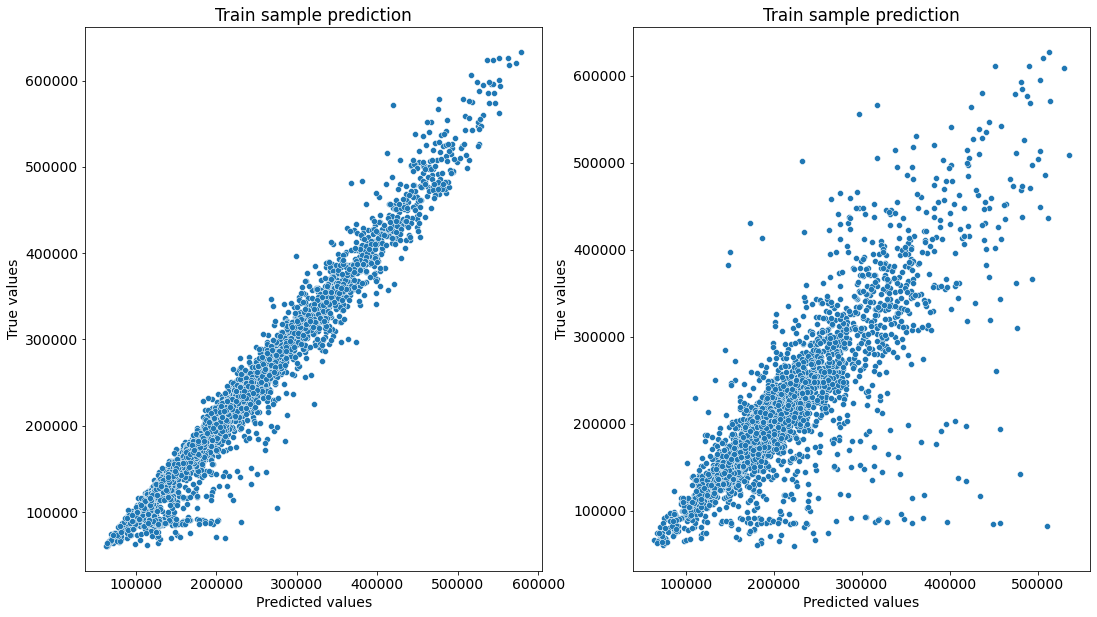

In [49]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

### Работа с тестовыми данными


Работа с тестовыми данными будет включать в себя аналогичные действия с обучающими данными

### Приведение типов

In [50]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Приводим не числовые признаки к строковому значению (Id и DistrictId)

In [51]:
test_df['Id'] = test_df['Id'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)
test_df['HouseFloor'] = test_df['HouseFloor'].astype(int)

In [52]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   object 
 1   DistrictId     5000 non-null   object 
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   int32  
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Id и DistrictId изменили значение с float64 на object

### Рассматриваем количественные показатели

In [53]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


В представленных данных, мы можем наблюдать как и в данных обучающей выборки ряд аномалий. Например минамальная площадь 1,3 кв.м., жилая площадь 0,33 кв.м. и ряд других. Учитывая особенности задания, мы не можем удалять данные

### Обработка выбросов

__`работа с выбросами в колонке Rooms`__

In [54]:
test_df['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
6.0        2
0.0        2
17.0       1
Name: Rooms, dtype: int64

Среди явных аномальных значений мы наблюдаем следующие: 2 квартиры с количеством комнат 0 и 1 квартира с 17 комнатами. Так как точных данных по количеству комнат в этих домах не известно, установим среднее значение.

In [55]:
test_df.loc[test_df['Rooms'].isin([0, 17]), 'Rooms'] = test_df['Rooms'].median()

test_df['Rooms'].value_counts()

2.0    2033
1.0    1769
3.0    1099
4.0      90
5.0       7
6.0       2
Name: Rooms, dtype: int64

Мы видим, что после преобразований, аномалий по количеству комнат больше нет

__`Работа с выбросами в колонках  Square, LifeSquare`__

Поскольку в тренировочной выборке можно было удалять строки, а в тестовой нет, то нам необходимо заменять аномалии медианой

In [56]:
test_df.loc[test_df['Square'].isin([0]), 'Square'] = test_df['Square'].median()

In [57]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = test_df['LifeSquare'].median()

In [58]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   object 
 1   DistrictId     5000 non-null   object 
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   int32  
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Пропуски заполнены медианой

__`Работа с выбросами в колонках HouseFloor, Floor`__

In [59]:
test_df['HouseFloor'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 36, 37, 39, 40, 48, 99])

Среди аномалий явно этажность здания 0. Заменим средним значением

In [60]:
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = test_df['HouseFloor'].median()
test_df.loc[test_df['HouseFloor'] > 99, 'HouseFloor'] = test_df['HouseFloor'].median()

In [61]:
test_df['HouseFloor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       36, 37, 39, 40, 48, 99])

более аномалии 0 мы не наблюдаем

In [62]:
test_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 38, 46,
       78], dtype=int64)

Исключаем варианты когда этаж на котором расположена квартира, выше чем этажность дома

In [63]:
floor_outliers = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index

test_df.loc[floor_outliers, 'Floor'] = test_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [64]:
test_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 31, 32, 33, 34, 38, 46],
      dtype=int64)

После проведенной очистки можно наблюдать, что из изначальных данных пропали квартиры расположенные на 27 и 78 этажах

__`Работа с выбросами в колонке HouseYear`__

In [65]:
test_df['HouseYear'].sort_values(ascending=False)

385     2020
888     2020
4273    2020
1275    2020
3382    2020
        ... 
1475    1912
64      1911
2691    1910
2       1909
3253    1908
Name: HouseYear, Length: 5000, dtype: int64

Аномалий в информации с годом постройки дома не наблюдаем


### Проверка пропусков

In [66]:
len(test_df) - test_df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

__`Заполняем пропуски в поле Healthcare_1`__

In [67]:
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = test_df['Healthcare_1'].median()

In [68]:
len(test_df) - test_df.count()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

пустых значений в поле Healthcare_1 не осталось

__`Переводим тип object в числовое значение в Ecology_2,3 и Shops_2`__

In [69]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A' :0, 'B' :1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A' :0, 'B' :1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A' :0, 'B' :1})

### DistrictSize, IsDistrictLardge

In [70]:
district_size = test_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,391
1,1,344
2,23,264
3,6,257
4,9,132


In [71]:
test_df = test_df.merge(district_size, on='DistrictId', how='left')

test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,725,58,2.0,49.882643,33.432782,6.0,6,14,1972,0.310199,...,2748,1,900.0,0,0,B,1,1,1,91
1,15856,74,2.0,69.263183,32.925087,1.0,1,1,1977,0.075779,...,1437,3,900.0,0,2,B,1,1,1,61
2,5480,190,1.0,13.597819,15.948246,12.0,2,5,1909,0.000000,...,7538,87,4702.0,5,5,B,1,1,1,2
3,15664,47,2.0,73.046609,51.940842,9.0,22,22,2007,0.101872,...,4583,3,900.0,3,3,B,1,1,1,49
4,14275,27,1.0,47.527111,43.387569,1.0,17,17,2017,0.072158,...,629,1,900.0,0,0,A,1,1,0,391


In [72]:
(test_df['DistrictSize'] > 100).value_counts()

False    3375
True     1625
Name: DistrictSize, dtype: int64

In [73]:
test_df['IdDistrictLarge'] = (test_df['DistrictSize'] > 100).astype(int)

### Отбор признаков

In [75]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'IdDistrictLarge',
 'MedPriceByDistrict']

In [76]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3', 
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

new_feature_names = ['IdDistrictLarge']


In [77]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               5000 non-null   object 
 1   DistrictId       5000 non-null   object 
 2   Rooms            5000 non-null   float64
 3   Square           5000 non-null   float64
 4   LifeSquare       5000 non-null   float64
 5   KitchenSquare    5000 non-null   float64
 6   Floor            5000 non-null   int64  
 7   HouseFloor       5000 non-null   int32  
 8   HouseYear        5000 non-null   int64  
 9   Ecology_1        5000 non-null   float64
 10  Ecology_2        5000 non-null   object 
 11  Ecology_3        5000 non-null   object 
 12  Social_1         5000 non-null   int64  
 13  Social_2         5000 non-null   int64  
 14  Social_3         5000 non-null   int64  
 15  Healthcare_1     5000 non-null   float64
 16  Helthcare_2      5000 non-null   int64  
 17  Shops_1       

### Работа с предсказаниями

Используем модель RandomForestRegressor

In [78]:
X_test = test_df[feature_names + new_feature_names]
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rooms            5000 non-null   float64
 1   Square           5000 non-null   float64
 2   LifeSquare       5000 non-null   float64
 3   KitchenSquare    5000 non-null   float64
 4   Floor            5000 non-null   int64  
 5   HouseFloor       5000 non-null   int32  
 6   HouseYear        5000 non-null   int64  
 7   Ecology_1        5000 non-null   float64
 8   Ecology_2_bin    5000 non-null   int64  
 9   Ecology_3_bin    5000 non-null   int64  
 10  Social_1         5000 non-null   int64  
 11  Social_2         5000 non-null   int64  
 12  Social_3         5000 non-null   int64  
 13  Healthcare_1     5000 non-null   float64
 14  Helthcare_2      5000 non-null   int64  
 15  Shops_1          5000 non-null   int64  
 16  Shops_2_bin      5000 non-null   int64  
 17  IdDistrictLarg

In [79]:
y_test_pred = rf_model.predict(X_test)

In [83]:
test_df['Price'] = y_test_pred
test_df.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IdDistrictLarge,Price
0,725,58,2.0,49.882643,33.432782,6.0,6,14,1972,0.310199,...,900.0,0,0,B,1,1,1,91,0,164941.392822
1,15856,74,2.0,69.263183,32.925087,1.0,1,1,1977,0.075779,...,900.0,0,2,B,1,1,1,61,0,211793.980189
2,5480,190,1.0,13.597819,15.948246,12.0,2,5,1909,0.000000,...,4702.0,5,5,B,1,1,1,2,0,196080.722669
3,15664,47,2.0,73.046609,51.940842,9.0,22,22,2007,0.101872,...,900.0,3,3,B,1,1,1,49,0,350343.003020
4,14275,27,1.0,47.527111,43.387569,1.0,17,17,2017,0.072158,...,900.0,0,0,A,1,1,0,391,1,132285.968267


In [81]:
pd.DataFrame({ 'Id': test_df['Id'], 'Price': test_df['Price']}).to_csv('AVShaidulin_predictions.csv', sep =',', index=False)